## Identifying Spike Sequences in Songbird HVC

This notebook shows how to use this package to fit the sequence detection model described in:

> Williams AH, Degleris A, Wang Y, Linderman SW (2020).  Point process models for sequence detection in high-dimensional neural spike trains. *NeurIPS 2020*, Vancouver, CA.

The dataset analyzed in this notebook was originally described and published in:

> Mackevicius EL, Bahle AH, Williams AH, Gu S, Denisenko NI, Goldman MS, Fee MS (2019). [Unsupervised discovery of temporal sequences in high-dimensional datasets, with applications to neuroscience](https://elifesciences.org/articles/38471). *Elife*, 8, e38471. [**[link to original dataset and code.]**](https://github.com/FeeLab/seqNMF)

Note that these are deconvolved spikes from a calcium imaging experiment from one bird.

In [1]:
# Import PPSeq
import PPSeq
const seq = PPSeq

# Other Imports
import PyPlot: plt
import DelimitedFiles: readdlm
import Random
import StatsBase: quantile

# Songbird metadata
num_neurons = 75
max_time = 22.2

# Randomly permute neuron labels.
# (This hides the sequences, to make things interesting.)
_p = Random.randperm(num_neurons)

# Load spikes.
spikes = seq.Spike[]
for (n, t) in eachrow(readdlm("data/songbird_spikes.txt", '\t', Float64, '\n'))
    push!(spikes, seq.Spike(_p[Int(n)], t))
end

┌ Info: Precompiling PPSeq [bde08ef1-7bcc-48ee-8e40-33ae55139814]
└ @ Base loading.jl:1278


## Plot a spike raster

Some useful visualization functions are provided for you in `src/utils/visualization.jl`

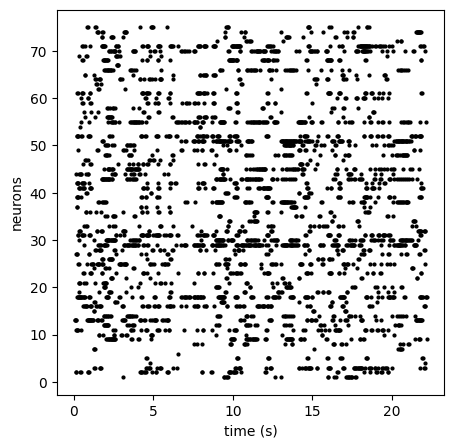

In [2]:
fig = seq.plot_raster(spikes; color="k") # returns matplotlib Figure
fig.set_size_inches([5, 5]);

## Specify PP-Seq model

There are a lot of hyperparameters associated with the pp-Seq model and the MCMC inference procedure. To make things as simple as possible, we create a "config dict" which specifies them all in one place. The table below summarizes the model hyperparameters.

| hyperparameter                | symbol         | Notes |
|:------------------------------|:--------------:|:---------------------|
| num_sequence_types            | $R$            | Number of unique sequence patterns
| seq_type_conc_param           | $\gamma$       | Specifies Dirichlet prior on sequence type probabilities
| seq_event_rate                | $\psi$         | Specifies homogeneous Poisson process for latent events
| mean_event_amplitude          |  N/A           | Specifies $\alpha$ and $\beta$ (supp. eq. #) along with var_event_amplitude
| var_event_amplitude           |  N/A           | Specifies $\alpha$ and $\beta$ (supp. eq. #) along with mean_event_amplitude
| neuron_response_conc_param    | $\varphi$      | Specifies Dirichlet prior on evoked response amplitudes in neural firing rate amplitudes
| neuron_offset_pseudo_obs      | $\kappa$       | Psuedo-observations on mean, Normal-Inverse-Chi-Squared prior
| neuron_width_pseudo_obs       | $\nu$          | Psuedo-observations on variance, Normal-Inverse-Chi-Squared prior 
| neuron_width_prior            | $\sigma^2$     | Variance parameter on Normal-Inverse-Chi-Squared prior
| mean_bkgd_spike_rate          | N/A            | Specifies the mean of Gamma prior on $\lambda_\varnothing$ (specifies $\alpha_\varnothing$ and $\beta_\varnothing$ along with var_bkgd_spike_rate)
| var_bkgd_spike_rate          | N/A            | Specifies the variance of Gamma prior on $\lambda_\varnothing$ (specifies $\alpha_\varnothing$ and $\beta_\varnothing$ along with mean_bkgd_spike_rate)
| bkgd_spikes_conc_param      | $\gamma_\varnothing$ | Specifies Dirichlet prior on relative background firing rates (supp. eq. #)

In [3]:
config = Dict(

    # Model hyperparameters
    :num_sequence_types =>  2,
    :seq_type_conc_param => 1.0,
    :seq_event_rate => 1.0,

    :mean_event_amplitude => 100.0,
    :var_event_amplitude => 1000.0,
    
    :neuron_response_conc_param => 0.1,
    :neuron_offset_pseudo_obs => 1.0,
    :neuron_width_pseudo_obs => 1.0,
    :neuron_width_prior => 0.5,
    
    :num_warp_values => 1,
    :max_warp => 1.0,
    :warp_variance => 1.0,

    :mean_bkgd_spike_rate => 30.0,
    :var_bkgd_spike_rate => 30.0,
    :bkgd_spikes_conc_param => 0.3,
    :max_sequence_length => Inf,
    
    # MCMC Sampling parameters.
    :num_anneals => 10,
    :samples_per_anneal => 100,
    :max_temperature => 40.0,
    :save_every_during_anneal => 10,
    :samples_after_anneal => 2000,
    :save_every_after_anneal => 10,
    :split_merge_moves_during_anneal => 10,
    :split_merge_moves_after_anneal => 10,
    :split_merge_window => 1.0,

);

## Train PPSeq model

The `easy_sample!(...)` function is defined in `src/algorithms/easy_sample.jl`. It uses an annealing procedure during the initial MCMC burn-in. See our paper for more details on the specifics of MCMC sampling (Williams et al., 2020).

In [4]:
# Initialize all spikes to background process.
init_assignments = fill(-1, length(spikes))

# Construct model struct (PPSeq instance).
model = seq.construct_model(config, max_time, num_neurons)

# Run Gibbs sampling with an initial annealing period.
results = seq.easy_sample!(model, spikes, init_assignments, config);

(warp_values, warp_log_proportions) = ([1.0], [0.0])
TEMP:  39.99999999999999
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  26.549315324802276
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  17.621653605394528
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  11.696070952851464
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  7.763066894712855
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  5.152602771881631
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  3.419951893353394
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  2.269934530307346
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.5066301902946675
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.0
10-20-30-40-50-60-70-80-90-100-Done
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-

## Plot results

#### Plot raster plot with labeled sequences

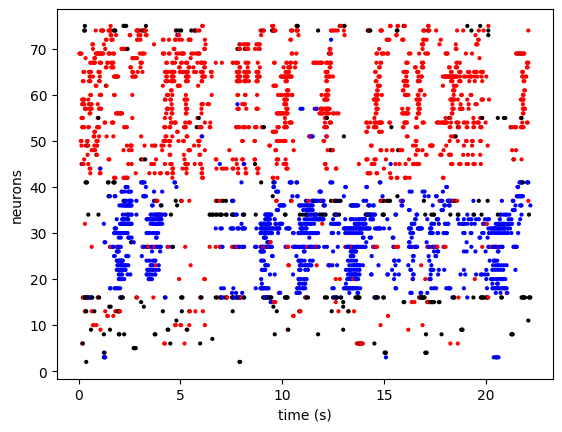

In [5]:
# Grab the final MCMC sample
final_globals = results[:globals_hist][end]
final_events = results[:latent_event_hist][end]
final_assignments = results[:assignment_hist][:, end]

# Helpful utility function that sorts the neurons to reveal sequences.
neuron_ordering = seq.sortperm_neurons(final_globals)

# Plot model-annotated raster.
seq.plot_raster(
    spikes,
    final_events,
    final_assignments,
    neuron_ordering
);

#### Plot log-likelihood over MCMC samples

The log-likelihoods during the annealing period are stored in `results[:anneal_log_p_hist]`.

The log-likelihoods during the post-anneal period are stored in `results[:log_p_hist]`.

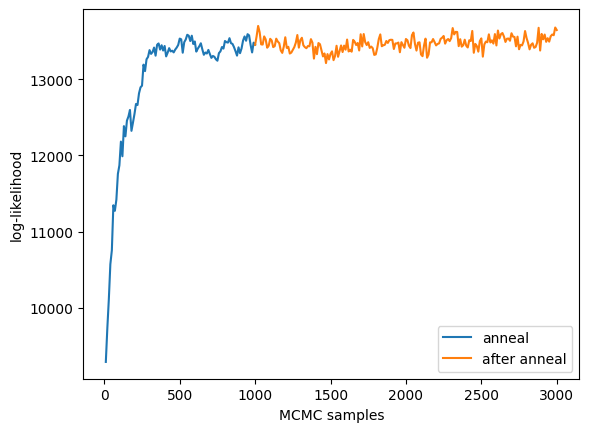

In [6]:
seq.plot_log_likes(config, results);

#### Plot number of latent events (i.e. number of sequences) over MCMC samples

The latent events during the annealing period are stored in `results[:anneal_latent_event_hist]`.

The log-likelihoods during the post-anneal period are stored in `results[:latent_event_hist]`.

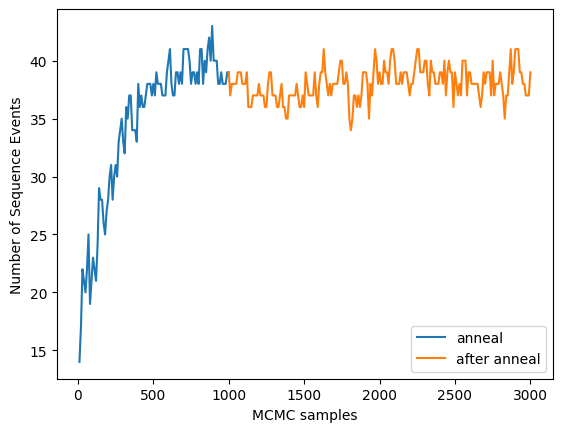

In [7]:
seq.plot_num_seq_events(config, results);

### Plot Firing Rates

Now we'll plot the firing rate estimate of the model on the last MCMC sample.

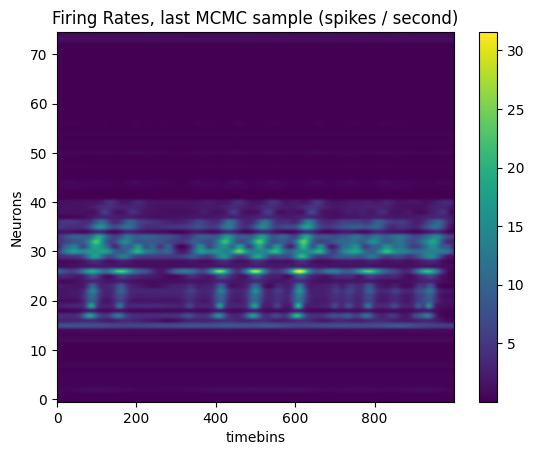

In [8]:
# Create discrete time grid.
num_timebins = 1000
dt = max_time / num_timebins
timebins = collect((0.5 * dt):dt:max_time)

# Compute a matrix firing rates (num_neurons x num_timebins)
F = seq.firing_rates(
    final_globals,
    final_events,
    timebins
)

# Plot firing rates as a heatmap
plt.imshow(F[neuron_ordering, :]; aspect="auto", origin="lower")
plt.title("Firing Rates, last MCMC sample (spikes / second)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.colorbar();

This is somewhat hard to interpret because neurons have very different peak firing rates. To see the sequences better, we can re-scale the firing rates to range between zero and one for each neuron.

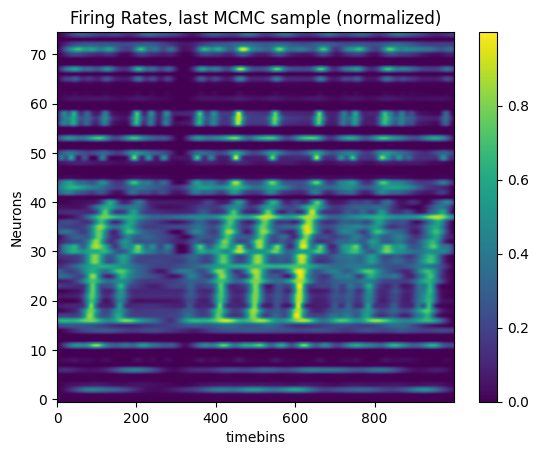

In [9]:
F_nrm = copy(F)
for n in 1:num_neurons
    F_nrm[n, :] .-= minimum(F[n, :])
    F_nrm[n, :] ./= maximum(F[n, :])
end

plt.title("Firing Rates, last MCMC sample (normalized)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.imshow(F_nrm[neuron_ordering, :]; aspect="auto", origin="lower")
plt.colorbar();

### Plot Expected Firing Rates Under the Posterior

Rather than just plotting the final sample, we can average the firing rate estimate over all MCMC samples in the post-annealing epoch.

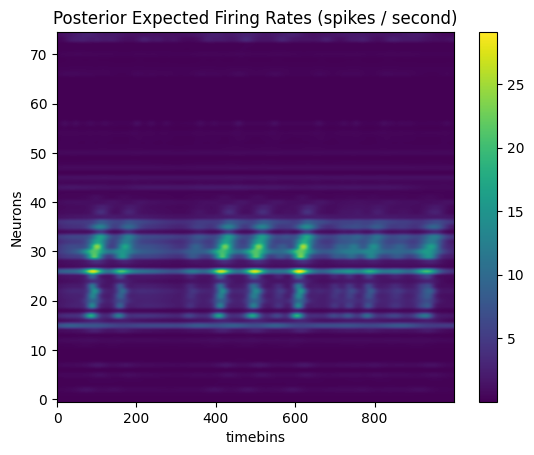

In [10]:
F_avg = zeros(num_neurons, num_timebins)

for (G, E) in zip(results[:globals_hist], results[:latent_event_hist])
    F_avg += seq.firing_rates(G, E, timebins)
end
F_avg ./= length(results[:globals_hist])

# Plot average firing rates as a heatmap
plt.imshow(F_avg[neuron_ordering, :]; aspect="auto", origin="lower")
plt.title("Posterior Expected Firing Rates (spikes / second)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.colorbar();

As before, this is somewhat difficult to visually inspect because the neurons have different firing rate magnitudes. Again, we can normalize the firing rates to range between zero and one.

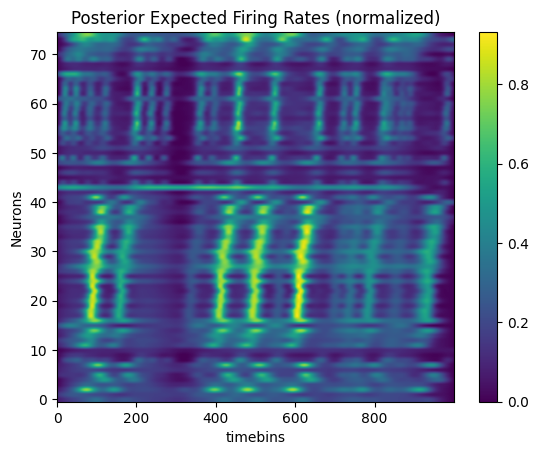

In [11]:
F_avg_nrm = copy(F_avg)
for n in 1:num_neurons
    F_avg_nrm[n, :] .-= minimum(F_avg[n, :])
    F_avg_nrm[n, :] ./= maximum(F_avg[n, :])
end

# Plot average firing rates as a heatmap
plt.imshow(F_avg_nrm[neuron_ordering, :]; aspect="auto", origin="lower")
plt.title("Posterior Expected Firing Rates (normalized)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.colorbar();